In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import json

In [118]:
input_file = "data-nutri-score-project.xlsx"

weights_w1 = {
    "Energy (kcal)": 4,
    "Sugars (g)": 3,
    "Saturated Fat (g)": 3,
    "Salt (g)": 3,
    "Proteins (g)": 2,
    "Fiber (g)": 2,
    "Fruits/Vegetables (%)": 1,
}

thresholds = [0.5, 0.55, 0.6]

In [119]:
def transform_criteria(row):

    transformed_row = row.copy()
    for criterion in row.index:
        if criterion in ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]:  # Minimized
            transformed_row[criterion] = 10 - row[criterion]
        elif criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:  # Maximized
            transformed_row[criterion] = 2 * row[criterion]
    return transformed_row

def compute_concordance(item, profile, weights):

    transformed_item = transform_criteria(item)
    concordance = 0
    total_weight = sum(weights.values())
    for criterion, value in profile.items():
        if criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:
            # Criteria to maximize
            if transformed_item[criterion] >= value:
                concordance += weights[criterion]
        else:
            # Criteria to minimize
            if transformed_item[criterion] <= value:
                concordance += weights[criterion]
    return concordance / total_weight

def pessimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    for category, profile in sorted(profiles.items()):
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category

## 1. Setting the limiting profiles manually (for instance, you could play yourself the role of the Decision Maker)

In [120]:
# Define limiting profiles for Nutri-Score categories (A to E)
limiting_profiles_1 = {
    "A": {"Energy (kcal)": 335, "Sugars (g)": 5, "Saturated Fat (g)": 1, "Salt (g)": 0.1, "Proteins (g)": 8, "Fiber (g)": 10, "Fruits/Vegetables (%)": 40},
    "B": {"Energy (kcal)": 400, "Sugars (g)": 10, "Saturated Fat (g)": 2, "Salt (g)": 0.3, "Proteins (g)": 6, "Fiber (g)": 8, "Fruits/Vegetables (%)": 20},
    "C": {"Energy (kcal)": 500, "Sugars (g)": 15, "Saturated Fat (g)": 3, "Salt (g)": 0.5, "Proteins (g)": 4, "Fiber (g)": 5, "Fruits/Vegetables (%)": 10},
    "D": {"Energy (kcal)": 700, "Sugars (g)": 20, "Saturated Fat (g)": 5, "Salt (g)": 1.0, "Proteins (g)": 2, "Fiber (g)": 3, "Fruits/Vegetables (%)": 5},
    "E": {"Energy (kcal)": 900, "Sugars (g)": 30, "Saturated Fat (g)": 8, "Salt (g)": 2.0, "Proteins (g)": 0, "Fiber (g)": 0, "Fruits/Vegetables (%)": 0},
}

In [121]:
data = pd.read_excel(input_file)
results = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category = pessimistic_majority_sorting(row, limiting_profiles_1, weights_w1, lambda_value)

        results.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category
        })
df = pd.DataFrame(results)
df

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,A
1,cruesly mélange de noix,A,0.55,A
2,cruesly mélange de noix,A,0.60,A
3,Céréales Chocapic,A,0.50,A
4,Céréales Chocapic,A,0.55,A
...,...,...,...,...
2824,Bamboo,A,0.55,A
2825,Bamboo,A,0.60,A
2826,Müesli croccante all'avena,C,0.50,A
2827,Müesli croccante all'avena,C,0.55,A


## 2. Finding limiting profiles using quintile approach

In [122]:
#using segmentation approach (quantile approach) to find limiting profiles:
columns_to_min = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
columns_to_max = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]

quintiles_min = data[columns_to_min].quantile([0.2, 0.4, 0.6, 0.8])
quintiles_max = data[columns_to_max].quantile([0.2, 0.4, 0.6, 0.8])

print(f"To minimize : \n{quintiles_min}")
print(f"To maximize : \n{quintiles_max}")

To minimize : 
     Energy (kcal)  Sugars (g)  Saturated Fat (g)  Salt (g)
0.2          369.0    5.620000                0.6    0.0200
0.4          380.0   13.580000                1.2    0.0766
0.6          401.2   17.673333                2.0    0.2800
0.8          443.0   22.000000                3.8    0.6600
To maximize : 
     Proteins (g)  Fiber (g)  Fruits/Vegetables (%)
0.2           8.0        5.5                 0.0000
0.4           9.0        7.0                 0.0000
0.6          10.0        8.5                 1.5875
0.8          12.0       10.0                12.9800


In [123]:
data[columns_to_max].max().to_dict()

{'Proteins (g)': 80.0, 'Fiber (g)': 33.0, 'Fruits/Vegetables (%)': 99.796875}

In [124]:
limiting_profiles_2 = {
    "A": {**quintiles_min.loc[0.2].to_dict(), **data[columns_to_max].max().to_dict()},  # Min Q1 + Max valeurs
    "B": {**quintiles_min.loc[0.4].to_dict(), **quintiles_max.loc[0.8].to_dict()},     # Min Q2 + Max Q4
    "C": {**quintiles_min.loc[0.6].to_dict(), **quintiles_max.loc[0.6].to_dict()},     # Min Q3 + Max Q3
    "D": {**quintiles_min.loc[0.8].to_dict(), **quintiles_max.loc[0.4].to_dict()},     # Min Q4 + Max Q2
    "E": {**data[columns_to_min].max().to_dict(), **quintiles_max.loc[0.2].to_dict()}  # Max valeurs + Min Q1
}

limiting_profiles_2

{'A': {'Energy (kcal)': 369.0,
  'Sugars (g)': 5.620000000000002,
  'Saturated Fat (g)': 0.6,
  'Salt (g)': 0.02,
  'Proteins (g)': 80.0,
  'Fiber (g)': 33.0,
  'Fruits/Vegetables (%)': 99.796875},
 'B': {'Energy (kcal)': 380.0,
  'Sugars (g)': 13.58,
  'Saturated Fat (g)': 1.2,
  'Salt (g)': 0.07660000000000002,
  'Proteins (g)': 12.0,
  'Fiber (g)': 10.0,
  'Fruits/Vegetables (%)': 12.98},
 'C': {'Energy (kcal)': 401.19999999999993,
  'Sugars (g)': 17.673333333333595,
  'Saturated Fat (g)': 2.0,
  'Salt (g)': 0.28,
  'Proteins (g)': 10.0,
  'Fiber (g)': 8.5,
  'Fruits/Vegetables (%)': 1.5874999999999995},
 'D': {'Energy (kcal)': 443.0,
  'Sugars (g)': 22.0,
  'Saturated Fat (g)': 3.8,
  'Salt (g)': 0.66,
  'Proteins (g)': 9.0,
  'Fiber (g)': 7.0,
  'Fruits/Vegetables (%)': 0.0},
 'E': {'Energy (kcal)': 601.0,
  'Sugars (g)': 48.0,
  'Saturated Fat (g)': 20.7,
  'Salt (g)': 8.4,
  'Proteins (g)': 8.0,
  'Fiber (g)': 5.5,
  'Fruits/Vegetables (%)': 0.0}}

In [125]:
df_limit_profiles_2 = pd.DataFrame(limiting_profiles_2)
df_limit_profiles_2

,A,B,C,D,E
Energy (kcal),369.000000,380.0000,401.200000,443.00,601.0
Sugars (g),5.620000,13.5800,17.673333,22.00,48.0
Saturated Fat (g),0.600000,1.2000,2.000000,3.80,20.7
Salt (g),0.020000,0.0766,0.280000,0.66,8.4
Proteins (g),80.000000,12.0000,10.000000,9.00,8.0
Fiber (g),33.000000,10.0000,8.500000,7.00,5.5
Fruits/Vegetables (%),99.796875,12.9800,1.587500,0.00,0.0


In [126]:
data = pd.read_excel(input_file)
results_2 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_2 = pessimistic_majority_sorting(row, limiting_profiles_2, weights_w1, lambda_value)

        results_2.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_2
        })

df_2 = pd.DataFrame(results_2)
df_2

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,B
1,cruesly mélange de noix,A,0.55,B
2,cruesly mélange de noix,A,0.60,B
3,Céréales Chocapic,A,0.50,B
4,Céréales Chocapic,A,0.55,B
...,...,...,...,...
2824,Bamboo,A,0.55,B
2825,Bamboo,A,0.60,B
2826,Müesli croccante all'avena,C,0.50,B
2827,Müesli croccante all'avena,C,0.55,B


## 3. Finding limiting profiles using K-means

In [127]:
def calculate_limiting_profiles(input_file, num_clusters=5):
    df = pd.read_excel(input_file)
    nutritional_features = [
        "Energy (kcal)",
        "Sugars (g)",
        "Saturated Fat (g)",
        "Salt (g)",
        "Proteins (g)",
        "Fiber (g)",
        "Fruits/Vegetables (%)"
    ]
    data = df[nutritional_features].dropna()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    centroids = kmeans.cluster_centers_

    limiting_profiles = pd.DataFrame(
        centroids.T,  # Transpose to have rows as criteria
        index=nutritional_features,
        columns=["A", "B", "C", "D", "E"][:num_clusters]  # Nutri-Score categories as columns
    )

    return limiting_profiles

In [128]:
limiting_profiles_3 = calculate_limiting_profiles(input_file)
limiting_profiles_3

/home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,A,B,C,D,E
Energy (kcal),374.109269,213.000000,466.003286,426.291030,0.000000
Sugars (g),12.247907,7.866667,17.544085,19.060652,10.040000
Saturated Fat (g),1.173311,1.966667,4.853713,3.043512,1.050000
Salt (g),0.362684,0.260000,0.277018,0.325902,0.250500
Proteins (g),10.233188,6.500000,9.734885,9.870209,6.700000
Fiber (g),8.249171,5.766667,7.494956,7.200275,9.020000
Fruits/Vegetables (%),5.256934,7.518136,9.344656,8.114808,6.359783


In [129]:
results_3 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_3 = pessimistic_majority_sorting(row, limiting_profiles_3, weights_w1, lambda_value)

        results_3.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_3
        })

df_3 = pd.DataFrame(results_3)
df_3

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,A
1,cruesly mélange de noix,A,0.55,A
2,cruesly mélange de noix,A,0.60,A
3,Céréales Chocapic,A,0.50,A
4,Céréales Chocapic,A,0.55,A
...,...,...,...,...
2824,Bamboo,A,0.55,A
2825,Bamboo,A,0.60,A
2826,Müesli croccante all'avena,C,0.50,A
2827,Müesli croccante all'avena,C,0.55,A


## 4. Finding limiting profiles using UTA approach (voir notebook UTA_approach.ipynb)

In [130]:
file_path = "limiting_profiles_uta.json"
with open(file_path, "r") as file:
    limiting_profiles_4 = json.load(file)

limiting_profiles_4

{'A': {'Energy (kcal)': 494.0,
  'Sugars (g)': 25.0,
  'Salt (g)': 1.1,
  'Saturated Fat (g)': 4.8,
  'Proteins (g)': 80.0,
  'Fiber (g)': 27.5,
  'Fruits/Vegetables (%)': 99.796875},
 'B': {'Energy (kcal)': 508.0,
  'Sugars (g)': 27.1,
  'Salt (g)': 1.3075,
  'Saturated Fat (g)': 5.0,
  'Proteins (g)': 22.1,
  'Fiber (g)': 27.0,
  'Fruits/Vegetables (%)': 56.1875},
 'C': {'Energy (kcal)': 524.0,
  'Sugars (g)': 48.0,
  'Salt (g)': 2.0,
  'Saturated Fat (g)': 9.2,
  'Proteins (g)': 27.9,
  'Fiber (g)': 27.0,
  'Fruits/Vegetables (%)': 63.25},
 'D': {'Energy (kcal)': 601.0,
  'Sugars (g)': 39.0,
  'Salt (g)': 1.42,
  'Saturated Fat (g)': 20.7,
  'Proteins (g)': 16.0,
  'Fiber (g)': 14.0,
  'Fruits/Vegetables (%)': 70.0},
 'E': {'Energy (kcal)': 534.0,
  'Sugars (g)': 40.0,
  'Salt (g)': 1.67,
  'Saturated Fat (g)': 16.0,
  'Proteins (g)': 10.0,
  'Fiber (g)': 7.11,
  'Fruits/Vegetables (%)': 3.07161458333333}}

In [131]:
df_limit_profiles_4 = pd.DataFrame(limiting_profiles_4)
df_limit_profiles_4

,A,B,C,D,E
Energy (kcal),494.000000,508.0000,524.00,601.00,534.000000
Sugars (g),25.000000,27.1000,48.00,39.00,40.000000
Salt (g),1.100000,1.3075,2.00,1.42,1.670000
Saturated Fat (g),4.800000,5.0000,9.20,20.70,16.000000
Proteins (g),80.000000,22.1000,27.90,16.00,10.000000
Fiber (g),27.500000,27.0000,27.00,14.00,7.110000
Fruits/Vegetables (%),99.796875,56.1875,63.25,70.00,3.071615


In [132]:
results_4 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_4 = pessimistic_majority_sorting(row, limiting_profiles_4, weights_w1, lambda_value)

        results_4.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_4
        })

df_4 = pd.DataFrame(results_4)
df_4

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,C
1,cruesly mélange de noix,A,0.55,C
2,cruesly mélange de noix,A,0.60,D
3,Céréales Chocapic,A,0.50,C
4,Céréales Chocapic,A,0.55,C
...,...,...,...,...
2824,Bamboo,A,0.55,C
2825,Bamboo,A,0.60,D
2826,Müesli croccante all'avena,C,0.50,C
2827,Müesli croccante all'avena,C,0.55,C


## 5. Comparing results with the real Nutri-Score assignments (by using, for instance, a confusion matrix)

#### Limiting profiles set manually:

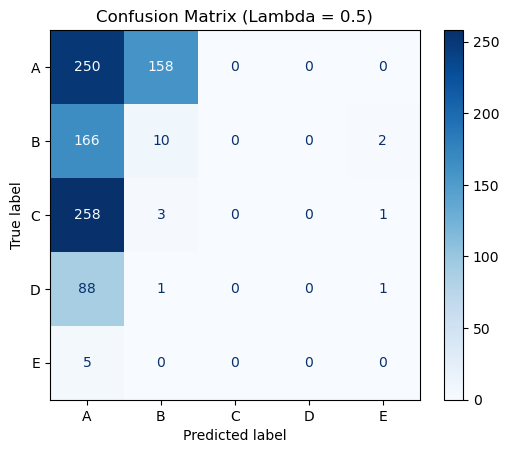

In [133]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df[df["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()


In [134]:
# Calculate and print accuracy
accuracy_1 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_1:.2f}")

# Calculate and print precision
precision_1 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_1:.2f}")

# Calculate and print recall
recall_1 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_1:.2f}")

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.28
Precision: 0.08
Recall: 0.13
F1 Score: 0.10


/home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


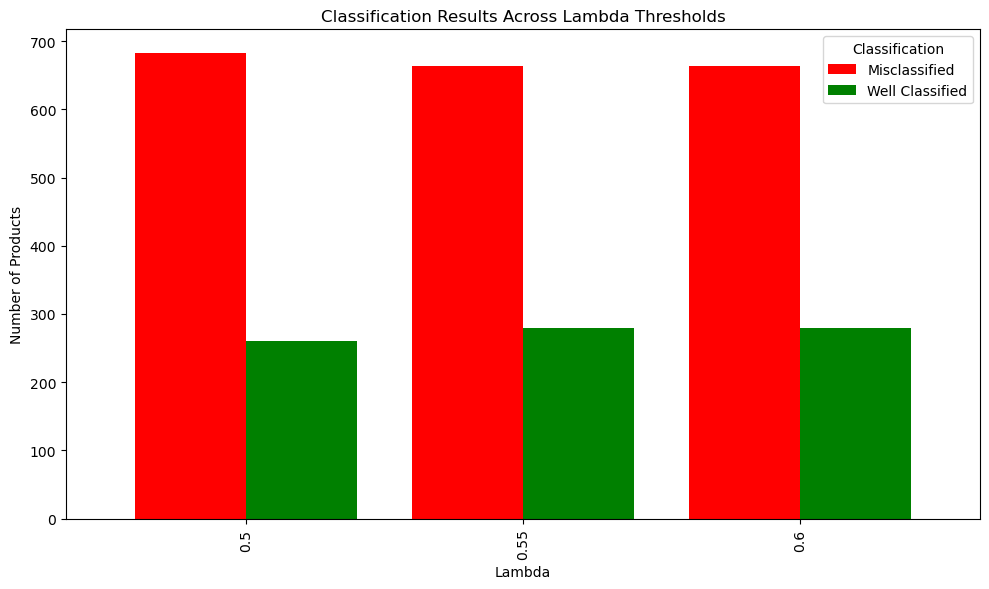

In [135]:
df['Well Classified'] = df['Nutri score'] == df['Pessimistic Category']
classification_counts = df.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 6), 
    color=['red', 'green'], 
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

#### Limiting profiles found with quantile approach:

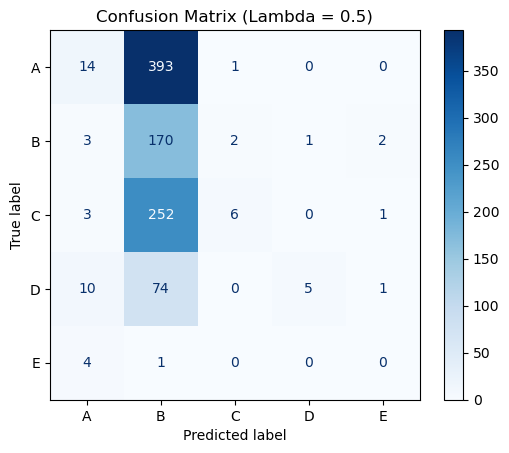

In [136]:
subset = df_2[df_2["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [137]:
# Calculate and print accuracy
accuracy_2 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_2:.2f}")

# Calculate and print precision
precision_2 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_2:.2f}")

# Calculate and print recall
recall_2 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_2:.2f}")

# Calculate and print F1 score
f2 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f2:.2f}")

Accuracy: 0.21
Precision: 0.42
Recall: 0.21
F1 Score: 0.11


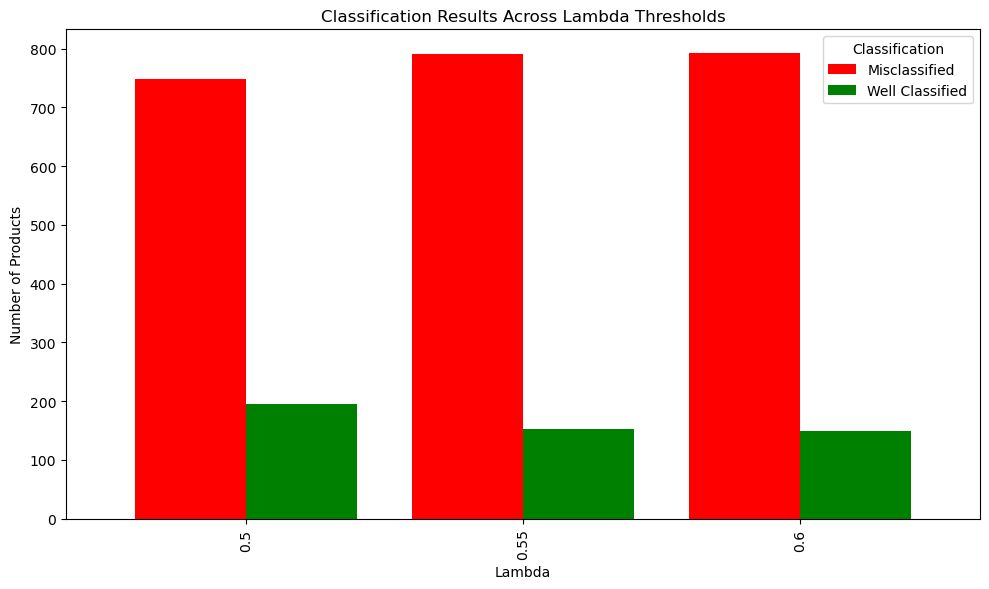

In [138]:
df_2['Well Classified'] = df_2['Nutri score'] == df_2['Pessimistic Category']
classification_counts = df_2.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 6), 
    color=['red', 'green'], 
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

#### Limiting profiles found using K-means:

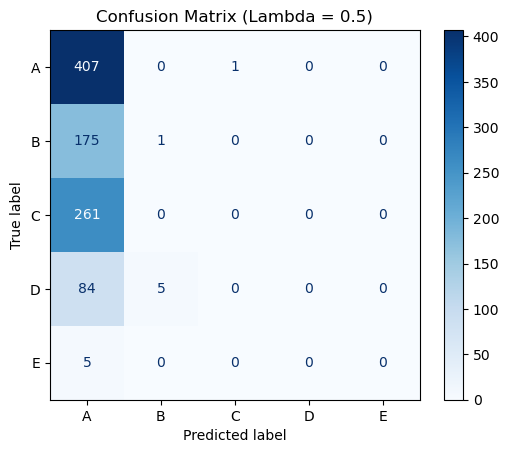

In [139]:
subset = df_3[df_3["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"].dropna()
y_pred = subset["Pessimistic Category"].dropna()
valid_indices = y_true.notnull() & y_pred.notnull()
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [140]:
# Calculate and print accuracy
accuracy_3 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_3:.2f}")

# Calculate and print precision
precision_3 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_3:.2f}")

# Calculate and print recall
recall_3 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_3:.2f}")

# Calculate and print F1 score
f3 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.43
Precision: 0.12
Recall: 0.20
F1 Score: 0.12


/home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


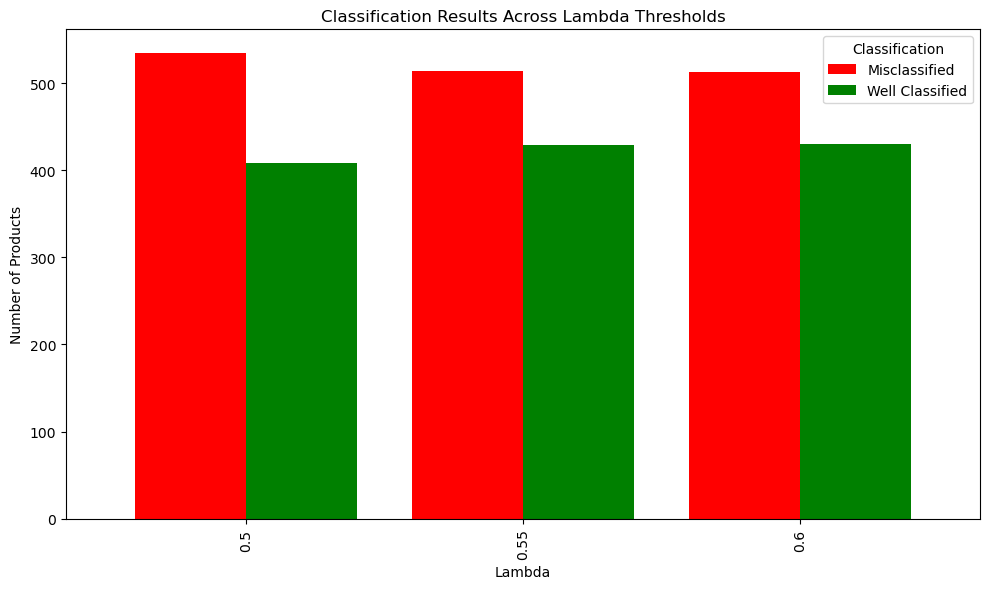

In [141]:
df_3['Well Classified'] = df_3['Nutri score'] == df_3['Pessimistic Category']
classification_counts = df_3.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 6), 
    color=['red', 'green'], 
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

#### Limiting profiles found usin UTA approach:

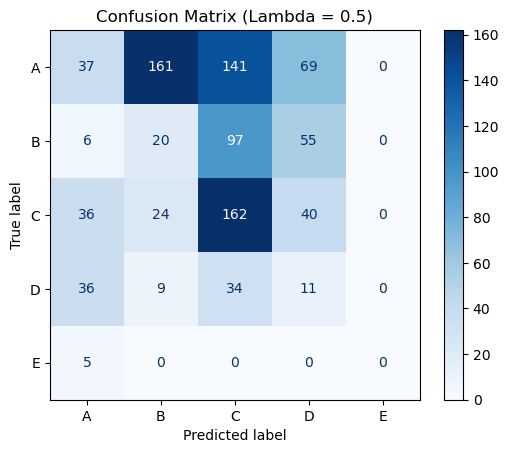

In [142]:
subset = df_4[df_4["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [143]:
# Calculate and print accuracy
accuracy_4 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_4:.2f}")

# Calculate and print precision
precision_4 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_4:.2f}")

# Calculate and print recall
recall_4 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_4:.2f}")

# Calculate and print F1 score
f4 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f4:.2f}")

Accuracy: 0.24
Precision: 0.17
Recall: 0.19
F1 Score: 0.16


/home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


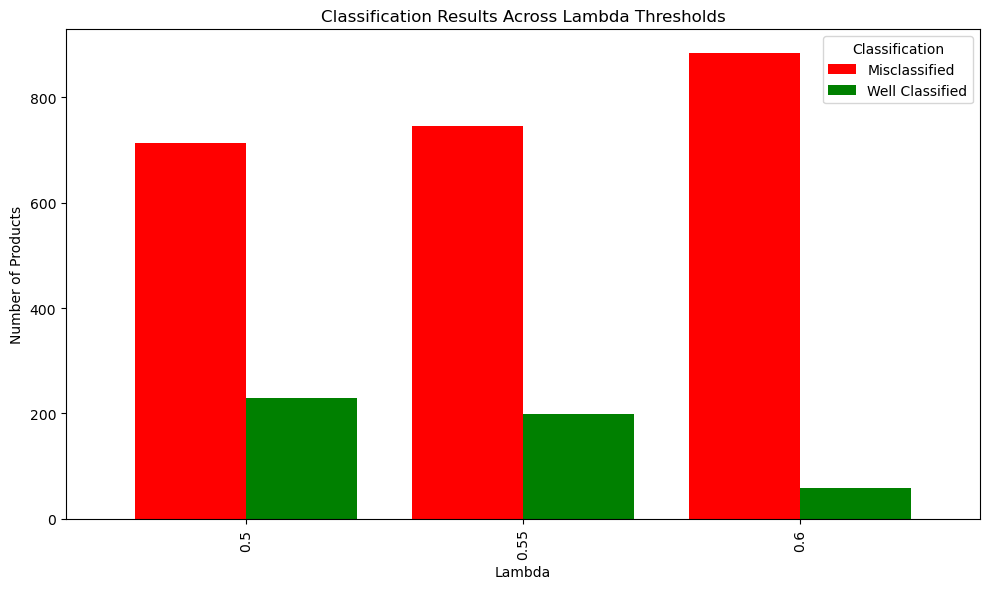

In [144]:
df_4['Well Classified'] = df_4['Nutri score'] == df_4['Pessimistic Category']
classification_counts = df_4.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 6), 
    color=['red', 'green'], 
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

## 6. Performance measures summary

In [145]:
data_sum = {
    "Limiting profiles - Approach": ['Manually', 'Quintiles', 'K-means', 'UTA'],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
    "Precision": [precision_1, precision_2, precision_3, precision_4],
    "Recall": [recall_1, recall_2, recall_3, recall_4],
    "F1 Score": [f1, f2, f3, f4],
}
performance_df = pd.DataFrame(data_sum)
performance_df

,Limiting profiles - Approach,Accuracy,Precision,Recall,F1 Score
0,Manually,0.275716,0.076817,0.133785,0.096535
1,Quintiles,0.206787,0.420555,0.213565,0.106030
2,K-means,0.434505,0.120672,0.200646,0.123690
3,UTA,0.243902,0.167584,0.188718,0.158146
